# Molecular VAE

In [47]:
# imports
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# chemistry
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  #set this to False if you want PNGs instead of SVGs

## Load data

In [2]:
chembl = pd.read_csv("data/cleaned_dataset.csv")
chembl.head()

,ChEMBL ID,Smiles,AlogP,QED Weighted
0,CHEMBL2333117,CC(C)Nc1c(C(N)=O)nnc2ccc(-c3cnn(C)c3)cc12,1.95,0.77
1,CHEMBL1189585,CC1C(=O)NC2=Nc3sc4c(c3CN21)CCCC4,1.95,0.78
2,CHEMBL4089494,CNC(=O)c1ccc(NC(=O)Nc2ccc(-c3nc(N4CCOCC4)c4ncc...,3.53,0.40
3,CHEMBL1189590,CN(C)c1nccc2c1nnn2Cc1ccccc1F,2.08,0.73
4,CHEMBL3927722,Cc1noc(C)c1Cn1cc(NC(=O)Cc2ccco2)cn1,2.31,0.78


## Build a vocabulary

Need to perform SMILES tokenization.  

In [81]:
import re

### Analyze token frequency

In [117]:
PAT = re.compile("(Br|Cl)")

def tokenize(smi:str, pat=None) -> list:
    """Tokenizes an input SMILES string"""
    if not pat:
        return list(smi)
    # split input SMILES string using the supplied regex pattern    
    splitted = pat.split(smi)
    tokens = []
    for i, s in enumerate(splitted):
        # make sure Br and Cl are treated as a single token
        if i % 2 == 0:
            tokens.extend(list(s))
        else:
            tokens.append(s)
    return tokens
    
def countTokens(smiles, tokenCol="token", cntCol="cnt", pat=None):
    """Computes the token frequency in the smiles iterable"""
    # special tokens regex pattern (Br and Cl atoms are encoded by 2 characters)
    token_cnts = {}
    for smi in smiles:
        # tokenize SMILES string
        tokenized = tokenize(smi, pat=pat)
        # count tokens
        for t in tokenized:
            try:
                token_cnts[t] += 1
            except KeyError:
                token_cnts[t] = 1
    return pd.DataFrame([[t, c] for t, c in token_cnts.items()], columns=[tokenCol, cntCol])


In [120]:
vocab = countTokens(chembl["Smiles"], pat=PAT)
vocab

,token,cnt
0,C,12896279
1,(,7025189
2,),7025189
3,N,2682981
4,c,18431345
5,1,4604265
6,=,2904352
7,O,4388805
8,n,2124346
9,2,3590237


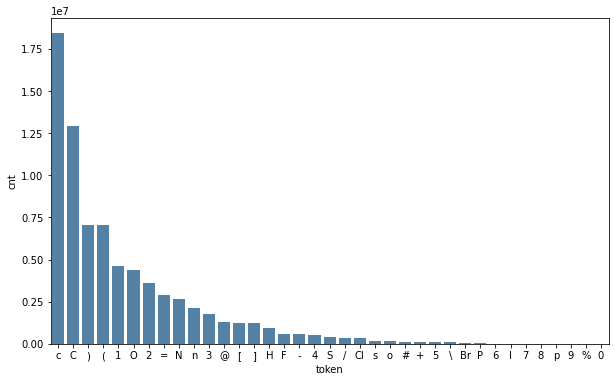

In [121]:
# plot token distribution
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.barplot(data=vocab.sort_values("cnt", ascending=False), x="token", y="cnt", color="steelblue", ax=ax)

### Build a vocabulary

In [32]:
# basic vocabulary
vocab = set()
for smi in chembl["Smiles"]:
    t = set(smi)
    vocab.update(t)


In [35]:
# add start/end characters
vocab.update({"<sos>", "<eos>", "<pad>"})
vocab

{'#',
 '%',
 '(',
 ')',
 '+',
 '-',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '<eos>',
 '<pad>',
 '<sos>',
 '=',
 '@',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'P',
 'S',
 '[',
 '\\',
 ']',
 'c',
 'l',
 'n',
 'o',
 'p',
 'r',
 's'}

In [41]:
# convert to dict
vocab_dict = {t:i for i, t in enumerate(vocab)}
vocab_dict

{'<pad>': 0,
 '0': 1,
 'B': 2,
 'F': 3,
 'P': 4,
 '5': 5,
 '<sos>': 6,
 '3': 7,
 'c': 8,
 '@': 9,
 'O': 10,
 '+': 11,
 'I': 12,
 '-': 13,
 ')': 14,
 '1': 15,
 '7': 16,
 '#': 17,
 'l': 18,
 ']': 19,
 '4': 20,
 'S': 21,
 '\\': 22,
 '[': 23,
 's': 24,
 '%': 25,
 '(': 26,
 '=': 27,
 '2': 28,
 'C': 29,
 '6': 30,
 'o': 31,
 'N': 32,
 'n': 33,
 'r': 34,
 '8': 35,
 'p': 36,
 '9': 37,
 'H': 38,
 '<eos>': 39,
 '/': 40}

## Encode input SMILES

Use the assembled vocabulary dict to convert SMILES strings to lists of integer indecies

In [42]:
def encode_smiles(smi, voc):
    tokens = list(smi)
    tokens = ["<sos>"] + tokens + ["<eos>"]
    return [voc[t] for t in tokens]
    

In [46]:
smi_sample = chembl["Smiles"].head(10)
smi_sample = [encode_smiles(smi, vocab_dict) for smi in smi_sample]
smi_sample

[[6,
  29,
  29,
  26,
  29,
  14,
  32,
  8,
  15,
  8,
  26,
  29,
  26,
  32,
  14,
  27,
  10,
  14,
  33,
  33,
  8,
  28,
  8,
  8,
  8,
  26,
  13,
  8,
  7,
  8,
  33,
  33,
  26,
  29,
  14,
  8,
  7,
  14,
  8,
  8,
  15,
  28,
  39],
 [6,
  29,
  29,
  15,
  29,
  26,
  27,
  10,
  14,
  32,
  29,
  28,
  27,
  32,
  8,
  7,
  24,
  8,
  20,
  8,
  26,
  8,
  7,
  29,
  32,
  28,
  15,
  14,
  29,
  29,
  29,
  29,
  20,
  39],
 [6,
  29,
  32,
  29,
  26,
  27,
  10,
  14,
  8,
  15,
  8,
  8,
  8,
  26,
  32,
  29,
  26,
  27,
  10,
  14,
  32,
  8,
  28,
  8,
  8,
  8,
  26,
  13,
  8,
  7,
  33,
  8,
  26,
  32,
  20,
  29,
  29,
  10,
  29,
  29,
  20,
  14,
  8,
  20,
  33,
  8,
  8,
  8,
  8,
  20,
  33,
  7,
  14,
  8,
  8,
  28,
  14,
  8,
  8,
  15,
  39],
 [6,
  29,
  32,
  26,
  29,
  14,
  8,
  15,
  33,
  8,
  8,
  8,
  28,
  8,
  15,
  33,
  33,
  33,
  28,
  29,
  8,
  15,
  8,
  8,
  8,
  8,
  8,
  15,
  3,
  39],
 [6,
  29,
  8,
  15,
  33,
  31,
  8,
  26,

## Embedding of tokens

In [48]:
torch.LongTensor(smi_sample)

ValueError: expected sequence of length 43 at dim 1 (got 34)